In [1]:
# simulate fringe frequency of the sun for different observation dates at Stockert obs.

# import packages
import numpy as np
import ephem
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fftpack import fft, fftfreq
from scipy import signal
import scipy.odr as sodr
from scipy.signal import find_peaks
import os
import astropy.units as u
import math
from astropy import constants as const


def wavel(freq,bandwidth):
    '''
    input: frequency and scan number
    calculate observation wavelength and write into output file
    output: observation wavelength
    '''
    # frequency and wavelength
    freq1=freq *1/u.s
    wavel=const.c/freq1
    # lower end of bandwidth
    freq_l=(freq-bandwidth/2) *1/u.s
    wavel_l=const.c/freq_l
    # upper end of badnwidth
    freq_u=(freq+bandwidth/2) *1/u.s
    wavel_u=const.c/freq_u
       
    return wavel, wavel_l, wavel_u


def baseline_length(baseline,B_x,B_y,B_z):
    '''
    input: baseline, scan number and x,y and z coordinates of baseline vector (x is in EW direction, y is in NS direction and z is height difference)
    output: length of baseline vector, hour angle and declination of intersection of baseline with northern hemisphere 
    '''
    
    
    D = np.sqrt(B_x**2+B_y**2+B_z**2)
    
    alpha = np.arctan2(B_y,B_x)
    
    decl = np.arctan2(B_z,D)
    
    return D, alpha, decl


def uvw(time_sun,wavel,ha_rad,dec,alpha, d,D):
    '''
    input: observation wavelength, hour angle and declination of sun, alpha and declination of baseline vector, and baseline length
    first calculate u,v and w coordinates in meters
    convert u,v and w coordinates to multiples of wavelength    
    output: u,v and w in wavelength
    '''
        
    ha_plus=(90)*np.pi/180 +alpha
    ha_minus=ha_plus-np.pi
    
    u_m= D*u.m*np.cos(d)*np.sin(ha_rad-ha_plus) 
    v_m= D*u.m*(np.sin(d)*np.cos(dec)-np.cos(d)*np.sin(dec)*np.cos(ha_rad-ha_plus)) 
    w_m= D*u.m*(np.sin(d)*np.sin(dec)+np.cos(d)*np.cos(dec)*np.cos(ha_rad-ha_plus))

    wavel_c=wavel[0]
    
    u_w = u_m/wavel_c
    v_w = v_m/wavel_c
    w_w = w_m/wavel_c
    
    u_w_b = D*u.m*np.cos(d)*np.sin(ha_rad-ha_plus) /wavel_c
    
    # min and max recoverable scale
    Arr_uv=np.sqrt(u_w**2+v_w**2)
    pos_min_uv=np.argmax(Arr_uv)
    u_min=u_w[pos_min_uv]
    v_min=v_w[pos_min_uv]
    pos_max_uv=np.argmin(Arr_uv)
    u_max=u_w[pos_max_uv]
    v_max=v_w[pos_max_uv]
    
    scale_min=np.degrees(1.0/np.nanmax(Arr_uv)*u.rad)
    print("min scale from uv coverage:", scale_min)
    print("time of min scale:", time_sun[pos_min_uv])
    scale_max=np.degrees(1.0/np.nanmin(Arr_uv)*u.rad)
    print("max scale from uv coverage:", scale_max)
    print("time of max scale:", time_sun[pos_max_uv])
    
    return u_w,v_w,w_w, u_w_b

In [2]:
# define Stockert Observatory
obs=ephem.Observer()
obs.lat='50.569417'
obs.lon='6.722'
obs.elevation=435
obs_day ='2024/9/21'  ##### THIS NEEDS TO BE CHANGED ACCORDING TO SIMULATION OF OBSERVATION DATE
obs.date=obs_day

# define time function:
def get_deg(time_str):
    h,m,s=time_str.split(':')
    return (float(h)*3600+float(m)*60+float(s))/3600

In [3]:
##### observation parameters

# frequency and wavelength
freq=1419e6 *1/u.s
wavel=wavel(1419e6,2e6)
print('Observed wavelength:', wavel)
obs_day ='2024/6/21'
obs.date=obs_day
print("Observation date:",obs.date)
sun=ephem.Sun()
sun.compute(obs)
sunrise=str(obs.next_rising(sun))
transit=str(obs.next_transit(sun))
sunset=str(obs.next_setting(sun))
print("sunrise at Stockert Observatory will be [UTC]: ",sunrise)
print("transit at Stockert Observatory will be [UTC]: ",transit)
print("sunset at Stockert Observatory will be [UTC]: ",sunset)

#print(sunrise[-8:-6])
Rise = int(sunrise[-8:-6]) + int(sunrise[-5:-3])/60 + int(sunrise[-2:])/3600
Transit= int(transit[-8:-6]) + int(transit[-5:-3])/60 + int(transit[-2:])/3600
Set = int(sunset[-8:-6]) + int(sunset[-5:-3])/60 + int(sunset[-2:])/3600

time_sun = np.linspace(Rise, Set, 10000)

# from measured data, calculate hour angle and declination of target(sun)
ha=np.array([])
ha_rad=np.array([])
dec=np.array([])
alt=np.array([])
for i in range(0,len(time_sun)):
    #print(time[i])
    obs.date=(''+str(obs_day)+' '+str(time_sun[i])+'')
    #print(obs.date)
    sun=ephem.Sun()
    sun.compute(obs)
    sun_ha=get_deg(str(sun.ha))
    
    if sun_ha>15:
        ha=np.append(ha,sun_ha-24)
    else:
        ha=np.append(ha,sun_ha)
    ha_rad=np.append(ha_rad,np.radians(ha[i]*15))
    #print(sun_ha, ha[i], ha_rad[i])
    sun_dec=sun.dec
    sun_alt=sun.alt
    sun_alt_deg=get_deg(str(sun_alt))
    #print(sun_alt_deg)
    #print(sun_dec)
    dec=np.append(dec,sun_dec)
    alt=np.append(alt,sun_alt_deg*np.pi/180)
    



Observed wavelength: (<Quantity 0.21127023 m>, <Quantity 0.21141922 m>, <Quantity 0.21112145 m>)
Observation date: 2024/6/21 00:00:00
sunrise at Stockert Observatory will be [UTC]:  2024/6/21 03:20:31
transit at Stockert Observatory will be [UTC]:  2024/6/21 11:35:02
sunset at Stockert Observatory will be [UTC]:  2024/6/21 19:49:32


min scale from uv coverage: 6.052446387552351 deg
time of min scale: 11.584574262981853
max scale from uv coverage: 15.21894344643916 deg
time of max scale: 17.585208770877088
min scale from uv coverage: 1.7292703964435294 deg
time of min scale: 11.584574262981853
max scale from uv coverage: 4.348269556125475 deg
time of max scale: 17.585208770877088
min scale from uv coverage: 0.5043705322960295 deg
time of min scale: 11.584574262981853
max scale from uv coverage: 1.2682452872032635 deg
time of max scale: 17.585208770877088


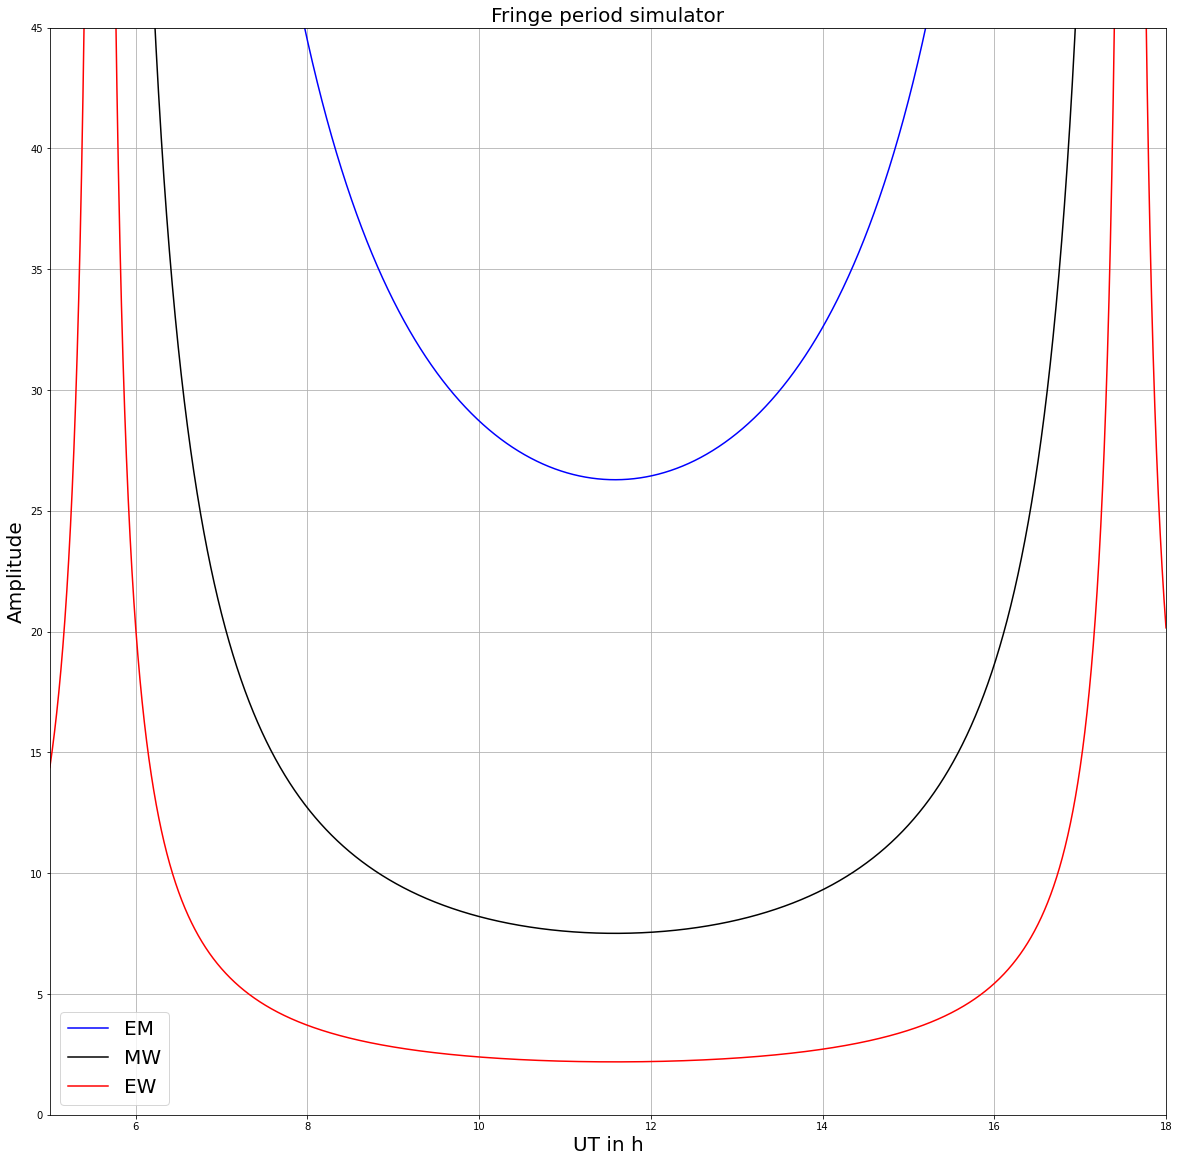

In [14]:
# According to baseline vector, calculate baseline length
D_em = baseline_length('EM',B_x=2,B_y=0,B_z=0)
D_mw = baseline_length('MW',B_x=7,B_y=0,B_z=0)
D_ew = baseline_length('EW',B_x=24,B_y=0.0,B_z=0.0)

# calculate and plot u,v and w coordinates in units of wavelength
uvw_em =uvw(time_sun,wavel,ha_rad,dec,alpha=D_em[1], d=D_em[2],D=D_em[0])
uvw_mw =uvw(time_sun,wavel,ha_rad,dec,alpha=D_mw[1], d=D_mw[2],D=D_mw[0])
uvw_ew =uvw(time_sun,wavel,ha_rad,dec,alpha=D_ew[1], d=D_ew[2],D=D_ew[0])


def fringe_period_simulator(u,dec):
    '''
    input: u (baseline in EW direction) and declination of the sun
    calculate fringe rate and then fringe period
    output: fringe period in minutes
    '''
    
    w_earth = 7.3*10**(-5) # in sec
    fringe_rate= u*w_earth*np.cos(dec) # 1/s
    fringe_period = (1/fringe_rate)/60 # in min
    
    return fringe_period

# fringe period simulator according to EW baseline and declination of sun for each baseline

fringe_em = fringe_period_simulator(uvw_em[3], dec)
fringe_ew = fringe_period_simulator(uvw_ew[3], dec)
fringe_mw = fringe_period_simulator(uvw_mw[3], dec)


plt.figure(figsize=(20,20))
plt.title("Fringe period simulator", fontsize=20)
plt.plot(time_sun, abs(fringe_em),color="blue",label="EM")
plt.plot(time_sun, abs(fringe_mw),color="black",label="MW")
plt.plot(time_sun, abs(fringe_ew),color="red",label="EW")
plt.xlabel('UT in h',fontsize=20)
plt.ylabel('Amplitude',fontsize=20)
plt.xlim(5,18)
plt.ylim(0,45)
plt.grid()
plt.legend(loc="best", prop={'size': 20})
plt.savefig('fringe_period_simulation.png',dpi=500,bbox_inches='tight')